<a href="https://colab.research.google.com/github/mc-robinson/RMD_colab_notebooks/blob/master/HERG_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HERG #

As used in [Ligand biological activity predicted by cleaning positive and negative chemical correlations](https://www.pnas.org/content/116/9/3373).

Now done with nested CV and more extensive hyperparameter optimization

In [0]:
!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y --prefix /usr/local -c rdkit rdkit

import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')

In [0]:
import PIL #needed for IPythonConsole

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole #needed to show molecules

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data_url = 'https://www.pnas.org/highwire/filestream/848445/field_highwire_adjunct_files/1/pnas.1810847116.sd01.xlsx'

mols_df = pd.read_excel(data_url, sheet_name='HERG')
mols_df.head()

,CANONICAL_SMILES,MOD,DOF_IC50_uM,Class,Source
0,c1cc(ccc1C(=O)Nc2ccn(n2)CCC#N)Cl,=,248.899834,Inactive,Pfizer
1,c1c2c([nH]n1)ncnc2N3CCCCC3,>,200.000000,Inactive,Pfizer
2,Cc1nc(on1)c2ccc(cc2)C(=O)OC,>,200.000000,Inactive,Pfizer
3,c1cc(cc(c1)F)NS(=O)(=O)c2cc(ccc2F)C(=O)O,>,200.000000,Inactive,Pfizer
4,Cc1nc(on1)c2ccc(cc2)C(=O)N,>,200.000000,Inactive,Pfizer


In [0]:
active_mols = [Chem.MolFromSmiles(smi) for smi
              in list(mols_df.loc[mols_df['Class']=='Active','CANONICAL_SMILES'])]
active_fps_list = [np.array(x) for x in [AllChem.GetMorganFingerprintAsBitVect(y,3,1024) for y in active_mols]]
active_fps_arr = np.vstack(active_fps_list)

In [0]:
decoy_mols = [Chem.MolFromSmiles(smi) for smi
              in list(mols_df.loc[mols_df['Class']=='Inactive','CANONICAL_SMILES'])]
decoy_fps_list = [np.array(x) for x in [AllChem.GetMorganFingerprintAsBitVect(y,3,1024) for y in decoy_mols]]
decoy_fps_arr = np.vstack(decoy_fps_list)

In [0]:
X = np.concatenate((active_fps_arr,decoy_fps_arr),axis=0)
y = np.concatenate((np.ones(active_fps_arr.shape[0]), np.zeros(decoy_fps_arr.shape[0])))

In [8]:
print(f'fingerprint length: {X.shape[1]}')
print(f'number of actives: {y[y==1].shape[0]}')
print(f'number of decoys: {y[y==0].shape[0]}')

fingerprint length: 1024
number of actives: 348
number of decoys: 2352


In [9]:
!git clone https://github.com/mc-robinson/RMD_colab_notebooks.git

Cloning into 'RMD_colab_notebooks'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [0]:
!cp RMD_colab_notebooks/chem_rmd.py .

In [0]:
def classical_AUC_CI(AUC, n_actives, n_inactives):
    import scipy.stats
    
    var_active = ((AUC**2)*(1-AUC)/(1+AUC))/n_actives
    var_inactive = (AUC*((1-AUC)**2)/(2-AUC))/n_inactives
    
    df_eff = (
        (((var_active/n_actives)+(var_inactive/n_inactives))**2) / 
        (
            (((var_active/n_actives)**2)/(n_actives-1)) +
            (((var_inactive/n_inactives)**2)/(n_inactives-1))
        )
    )
    
    std_error = np.sqrt(var_active+var_inactive)
    
    logit_auc = np.log(AUC/(1-AUC))
    logit_std_error = std_error * (1/(AUC*(1-AUC)))
    
    t_95 = scipy.stats.t.ppf(0.975,df_eff)
    logit_lower_limit = logit_auc - t_95*logit_std_error
    logit_upper_limit = logit_auc + t_95*logit_std_error
    
    lower_limit = 1/(1+np.exp(-1*logit_lower_limit))
    upper_limit = 1/(1+np.exp(-1*logit_upper_limit))
    
    return lower_limit, upper_limit


In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

def plot_roc_curves(y_test, y_scores, title='ROC curves'):

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure(figsize=(6,4))
    for i in range(len(y_scores)):
        # Compute ROC curve and area the curve
        scores = y_scores[i]
        classes = y_test[i]
        fpr, tpr, thresholds = roc_curve(classes, scores)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='Run %d (AUC = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    #print('mean auc', np.mean(aucs))
    if len(y_scores) > 1:
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')
    else:    
        n_actives = sum(y_test[y_test==1])
        n_inactives = sum(y_test[y_test==0])
        AUC_CI_lower, AUC_CI_upper = classical_AUC_CI(aucs[0],
                                                      n_actives,
                                                      n_inactives)
        plt.text(0.33,0.2,f'AUC CI from formula {round(AUC_CI_lower,3),round(AUC_CI_upper,3)}')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='upper center', bbox_to_anchor=(1.4, 1.0), shadow=True, ncol=1)
    plt.show()

In [0]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curves(y_test, y_scores, title='PR Curves'):

    precisions = []
    aucs = []
    mean_recall = np.linspace(0, 1, 100)

    plt.figure(figsize=(6,4))

    for i in range(len(y_scores)):
        scores = y_scores[i]
        classes = y_test[i]
        precision, recall, thresholds = precision_recall_curve(classes, scores)
        avg_precision = average_precision_score(classes, scores)
        aucs.append(avg_precision)
        #aucs.append(auc(recall, precision))
        plt.step(recall, precision, color='b', alpha=0.2,
             where='post',label='Run %d (AUC = %0.2f)' % (i, avg_precision))

        i += 1

    if len(y_scores)>1:
        print('MEAN PR-AUC:', np.mean(aucs))
        print('STD PR-AUC:', np.std(aucs))
        std_auc = np.std(aucs)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1), shadow=True, ncol=1)
    plt.show()

### Perform Nested Cross Validation On Each Algorithm ###

To be extra safe that the dataframe is not ordered in a way that could bias the data, first shuffle the data. Note that every random state in this dataset will be set to 42, to maintain reproducibility. 

In [0]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)

# RMD # 

In [0]:
from chem_rmd import RMD
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

def rmd_GridSearchCV(X, y, n_folds=5):
    
    scoring_list = ['theoretical', 'basic', 'weighted',
                    'dist_to_positive', 'dist_to_negative']
    scoring_dict = dict.fromkeys(scoring_list, 0)

    for scoring in scoring_list:
        sss = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=False)
        for train_index, test_index in sss.split(X, y): 
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            rmd = RMD()
            rmd.fit(X_train, y_train)
            y_pred = rmd.predict_scores(X_test,scoring=scoring )
            metric = roc_auc_score(y_test, y_pred)
            scoring_dict[scoring] = scoring_dict[scoring] + metric/n_folds
    
    #scoring_dict = {k,(v/n_folds) for k,v in scoring_dict.items()}
    best_scoring = [k for k,v in scoring_dict.items() if v==max(scoring_dict.values())][0]
    return best_scoring, scoring_dict

In [0]:
# nested CV

def nested_RMD_CV(X, y, n_outer_folds=5, n_inner_folds=4, verbose=True):
    
    y_test_list = []
    y_pred_list = []
    # Perform Outer CV Loop
    sss = StratifiedKFold(n_splits=n_outer_folds, random_state=42,
                          shuffle=False)
    for train_index, test_index in sss.split(X, y): 
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # inner loop
        best_scoring, _ = rmd_GridSearchCV(X_train, y_train,
                                           n_folds=n_inner_folds)
        
        # retrain best classifier on all of X_train, y_train
        rmd = RMD()
        rmd.fit(X_train, y_train)
        
        # test on outer test fold
        rmd_scores = rmd.predict_scores(X_test, scoring=best_scoring)
        metric = roc_auc_score(y_test, rmd_scores)
        
        y_test_list.append(y_test)
        y_pred_list.append(rmd_scores)
        
        if verbose:
            print('Best parameter value: ', best_scoring)
            print('ROC-AUC: ', metric)
        
    return y_test_list, y_pred_list

    

In [17]:
%%time
y_test_list, rmd_pred_list = nested_RMD_CV(X, y)

Best parameter value:  basic
ROC-AUC:  0.7894449499545041
Best parameter value:  basic
ROC-AUC:  0.8158022444646649
Best parameter value:  basic
ROC-AUC:  0.8256534954407294
Best parameter value:  basic
ROC-AUC:  0.815849522047487
Best parameter value:  basic
ROC-AUC:  0.8066604995374652
CPU times: user 10min 44s, sys: 3min 20s, total: 14min 4s
Wall time: 7min 6s


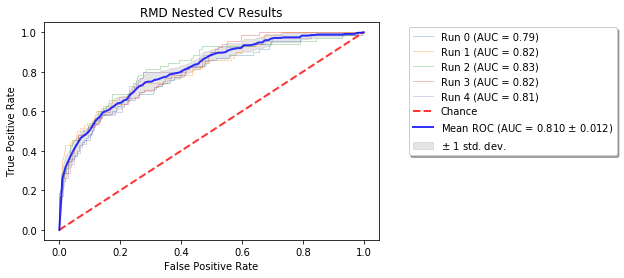

In [18]:
plot_roc_curves(y_test_list, rmd_pred_list, 'RMD Nested CV Results')

MEAN PR-AUC: 0.5286036957074433
STD PR-AUC: 0.024634154092792456


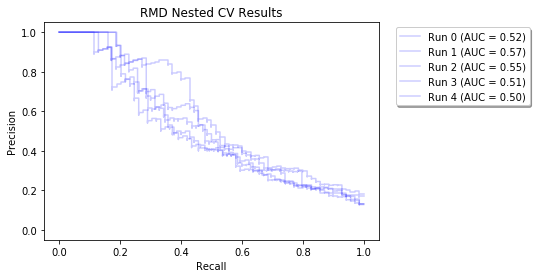

In [19]:
plot_pr_curves(y_test_list, rmd_pred_list, 'RMD Nested CV Results')

In [0]:
def nested_cv(X, y, clf, param_grid, n_jobs=-1, 
              n_outer_folds=5, n_inner_folds=4, verbose=0):
    
    from sklearn.model_selection import GridSearchCV
    
    y_test_list = []
    y_pred_list = []
    # Perform Outer CV Loop
    sss = StratifiedKFold(n_splits=n_outer_folds, random_state=42,
                          shuffle=False)
    for train_index, test_index in sss.split(X, y): 
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # inner loop
        # need to create own cv generator so set random state
        inner_cv =  StratifiedKFold(n_splits=n_inner_folds, random_state=42,
                                    shuffle=False)
        grid = GridSearchCV(clf,
                            cv=inner_cv,
                            n_jobs=n_jobs,
                            verbose=verbose,
                            param_grid=param_grid,
                            scoring='roc_auc')
        grid.fit(X_train, y_train)
        
        # retrain best classifier on all of X_train, y_train
        best_clf = grid.best_estimator_
        best_clf.fit(X_train, y_train)
        
        # test on outer test fold
        try:
            best_clf_scores = best_clf.decision_function(X_test)
        except(NotImplementedError, AttributeError):
            best_clf_scores = best_clf.predict_proba(X_test)[:,1]
            
        metric = roc_auc_score(y_test, best_clf_scores)
        
        y_test_list.append(y_test)
        y_pred_list.append(best_clf_scores)
        
        if verbose == 0:
            print('Best parameter values: ', grid.best_params_)
            print('Outer fold ROC-AUC: ', metric)
        
    return y_test_list, y_pred_list

# NB

In [21]:
%%time
from sklearn.naive_bayes import BernoulliNB

nb = BernoulliNB()
alpha_range = np.arange(0.0, 2, 0.1)
nb_param_grid = dict(alpha=alpha_range)

y_test_list, nb_pred_list = nested_cv(X, y, nb, nb_param_grid, n_jobs=-1, 
                                        n_outer_folds=5, n_inner_folds=4, verbose=0)

Best parameter values:  {'alpha': 0.9}
Outer fold ROC-AUC:  0.8727327873824688
Best parameter values:  {'alpha': 1.7000000000000002}
Outer fold ROC-AUC:  0.856657567485593
Best parameter values:  {'alpha': 1.3}
Outer fold ROC-AUC:  0.858145896656535
Best parameter values:  {'alpha': 1.8}
Outer fold ROC-AUC:  0.8528831329016342
Best parameter values:  {'alpha': 1.0}
Outer fold ROC-AUC:  0.8386370644465001
CPU times: user 1.58 s, sys: 557 ms, total: 2.14 s
Wall time: 43.8 s


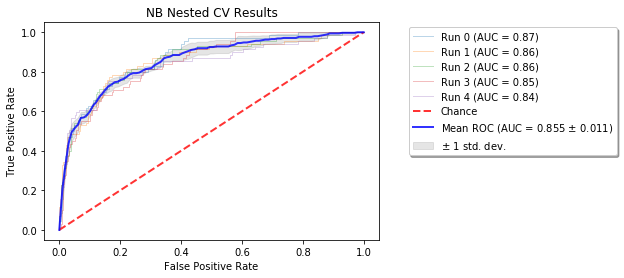

In [22]:
plot_roc_curves(y_test_list, nb_pred_list, 'NB Nested CV Results')

MEAN PR-AUC: 0.5606172422257162
STD PR-AUC: 0.0359115941463637


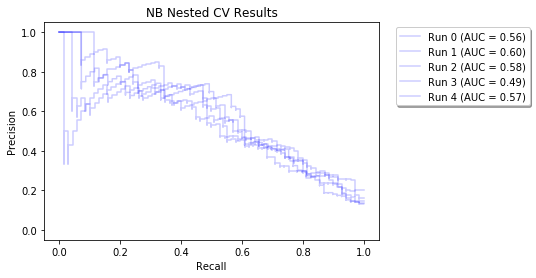

In [23]:
plot_pr_curves(y_test_list, nb_pred_list, 'NB Nested CV Results')

# KNN

In [24]:
%%time
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
neighbors_range = np.arange(2,8,1)
weights_range = ['uniform','distance']
knn_param_grid = dict(n_neighbors=neighbors_range, weights=weights_range)

y_test_list, knn_pred_list = nested_cv(X, y, knn, knn_param_grid, n_jobs=-1, 
                                        n_outer_folds=5, n_inner_folds=4, verbose=0)

Best parameter values:  {'n_neighbors': 7, 'weights': 'distance'}
Outer fold ROC-AUC:  0.6910069760388231
Best parameter values:  {'n_neighbors': 6, 'weights': 'distance'}
Outer fold ROC-AUC:  0.7290263876251136
Best parameter values:  {'n_neighbors': 6, 'weights': 'distance'}
Outer fold ROC-AUC:  0.7406838905775076
Best parameter values:  {'n_neighbors': 7, 'weights': 'distance'}
Outer fold ROC-AUC:  0.7409189022510022
Best parameter values:  {'n_neighbors': 7, 'weights': 'distance'}
Outer fold ROC-AUC:  0.6897317298797411
CPU times: user 17.3 s, sys: 132 ms, total: 17.5 s
Wall time: 21min 10s


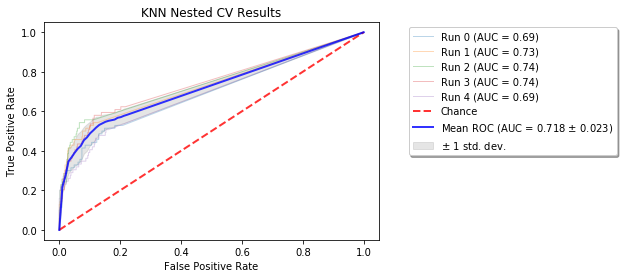

In [25]:
plot_roc_curves(y_test_list, knn_pred_list, 'KNN Nested CV Results')

MEAN PR-AUC: 0.43741109638501985
STD PR-AUC: 0.028774934639667314


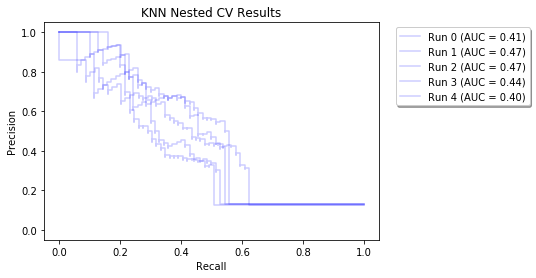

In [26]:
plot_pr_curves(y_test_list, knn_pred_list, 'KNN Nested CV Results')

# RF

In [27]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
n_estimators_range = [1000]
max_features_range = int(np.sqrt(X.shape[1])) * np.array([1,2,3])
rf_param_grid = dict(n_estimators=n_estimators_range,
                  max_features=max_features_range)

y_test_list, rf_pred_list = nested_cv(X, y, rf, rf_param_grid, n_jobs=-1, 
                                        n_outer_folds=5, n_inner_folds=4, verbose=0)

Best parameter values:  {'max_features': 64, 'n_estimators': 1000}
Outer fold ROC-AUC:  0.8763269639065817
Best parameter values:  {'max_features': 32, 'n_estimators': 1000}
Outer fold ROC-AUC:  0.8753867151956324
Best parameter values:  {'max_features': 32, 'n_estimators': 1000}
Outer fold ROC-AUC:  0.8786322188449849
Best parameter values:  {'max_features': 32, 'n_estimators': 1000}
Outer fold ROC-AUC:  0.877027443724946
Best parameter values:  {'max_features': 96, 'n_estimators': 1000}
Outer fold ROC-AUC:  0.8691489361702127
CPU times: user 2min 13s, sys: 180 ms, total: 2min 13s
Wall time: 11min 8s


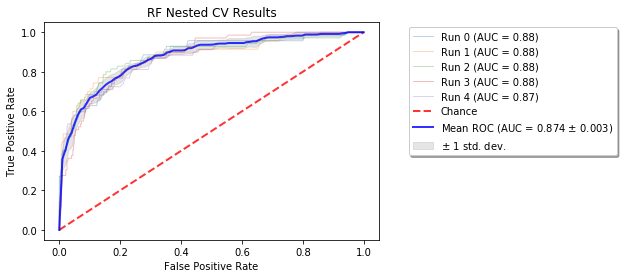

In [28]:
plot_roc_curves(y_test_list, rf_pred_list, 'RF Nested CV Results')

MEAN PR-AUC: 0.637162145854365
STD PR-AUC: 0.034155518183866786


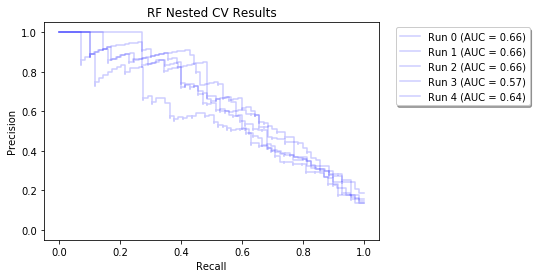

In [29]:
plot_pr_curves(y_test_list, rf_pred_list, 'RF Nested CV Results')

# SVM

In [30]:
%%time

from sklearn.svm import SVC

svm = SVC()
C_range = 10. ** np.arange(-1, 3, 1)
gamma_range = 10. ** np.arange(-3, 2, 2)
svm_param_grid = dict(gamma=gamma_range, C=C_range)

y_test_list, svm_pred_list = nested_cv(X, y, svm, svm_param_grid, n_jobs=-1, 
                                        n_outer_folds=5, n_inner_folds=4, verbose=0)

Best parameter values:  {'C': 1.0, 'gamma': 0.001}
Outer fold ROC-AUC:  0.8724901425538368
Best parameter values:  {'C': 1.0, 'gamma': 0.001}
Outer fold ROC-AUC:  0.8645131938125569
Best parameter values:  {'C': 0.1, 'gamma': 0.001}
Outer fold ROC-AUC:  0.8632826747720365
Best parameter values:  {'C': 1.0, 'gamma': 0.001}
Outer fold ROC-AUC:  0.8545174221399938
Best parameter values:  {'C': 1.0, 'gamma': 0.001}
Outer fold ROC-AUC:  0.8190872648781992
CPU times: user 34.8 s, sys: 124 ms, total: 35 s
Wall time: 19min 59s


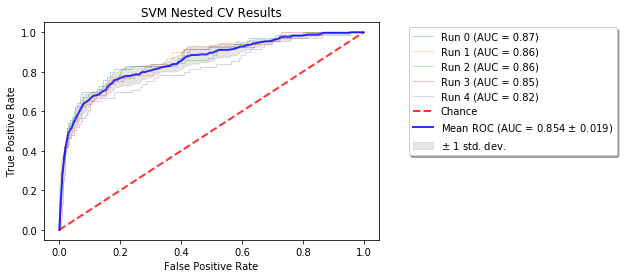

In [31]:
plot_roc_curves(y_test_list, svm_pred_list, 'SVM Nested CV Results')

MEAN PR-AUC: 0.6043153739990605
STD PR-AUC: 0.05167816856719335


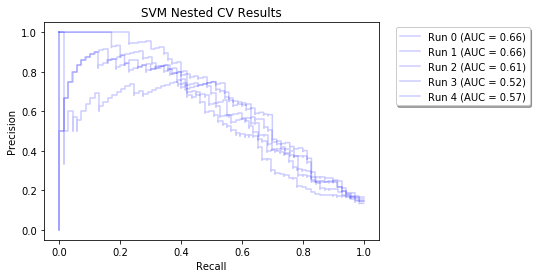

In [32]:
plot_pr_curves(y_test_list, svm_pred_list, 'SVM Nested CV Results')

# DNN

Note that this will not involve nested-CV, because no hyperparameter optimization will be done for ease of implementation. Sensible default values will be chosen and used across all folds

In [0]:
import torch
import fastai
from fastai.tabular import *

In [0]:
import torch.nn as nn
import torch.nn.functional as F

def bn_drop_lin(n_in:int, n_out:int, bn:bool=True,
                p:float=0., actn:Optional[nn.Module]=None):
    "`n_in`->bn->dropout->linear(`n_in`,`n_out`)->`actn`"
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

class Simple_DNN(nn.Module):
    def __init__(self, n_in, n_hidden=[512, 512, 512], n_out=2, dropout=0.5):
        super(Simple_DNN, self).__init__()
    
        layers = []
        layers += bn_drop_lin(n_in, n_hidden[0],
                              bn=False, p=0.0,
                              actn=nn.ReLU(inplace=True))
        for i in range(len(n_hidden)-1):
            layers += bn_drop_lin(n_hidden[i], n_hidden[i+1],
                                bn=False, p=dropout,
                                actn=nn.ReLU(inplace=True))
        layers += bn_drop_lin(n_hidden[-1], n_out,
                                bn=False, p=dropout,
                                actn=None)
    
        self.layers = nn.Sequential(*layers)
    
    def forward(self, xb):
        xb = self.layers(xb)
        return xb

In [0]:
def dnn_cv(X, y, n_outer_folds=5, verbose=True):
    
    y_test_list = []
    y_pred_list = []
    # Perform Outer CV Loop
    sss = StratifiedKFold(n_splits=n_outer_folds, random_state=42,
                          shuffle=False)
    for train_index, test_index in sss.split(X, y): 
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # convert to pytorch tensors
        X_train, y_train, X_test, y_test = \
        map(
          partial(torch.tensor, dtype=torch.float),
          (X_train, y_train, X_test, y_test)
        )
        y_train = y_train.long()
        y_test = y_test.long()

        # construct pytorch datasets
        train_ds = TensorDataset(X_train, y_train)
        test_ds = TensorDataset(X_test, y_test)

        # construct fastai databunch
        bs = 64
        data = DataBunch.create(train_ds, test_ds, bs=bs)
        
        # define and train dnn
        learn = Learner(data,
                Simple_DNN(n_in=X_train.shape[1],
                           n_hidden=[64,64],
                           n_out=2,
                           dropout=0.5),
                loss_func=CrossEntropyFlat())
        
        learn.fit_one_cycle(10, 1e-03)
        learn.fit_one_cycle(5, 1e-05)
        
        dnn_log_probs = get_preds(learn.model, data.valid_dl)[0]
        dnn_scores = np.exp(dnn_log_probs[:,1])
        
        metric = roc_auc_score(y_test, dnn_scores)
        
        y_test_list.append(y_test.numpy())
        y_pred_list.append(dnn_scores.numpy())
        
        if verbose:
            print('ROC-AUC: ', metric)
        
    return y_test_list, y_pred_list

In [36]:
%%time
y_test_list, dnn_pred_list = dnn_cv(X, y, n_outer_folds=5, verbose=True)

ROC-AUC:  0.7890533456675918
CPU times: user 15.5 s, sys: 6.57 s, total: 22.1 s
Wall time: 31.8 s


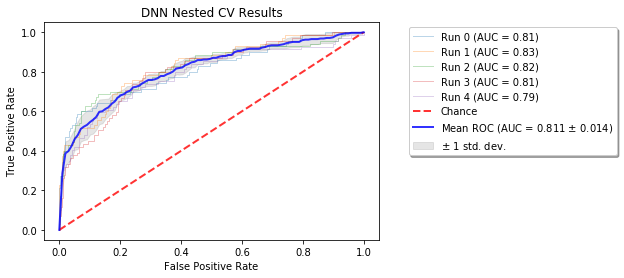

In [37]:
from sklearn.metrics import roc_curve, auc # b/c fastai was overwriting a metric
plot_roc_curves(y_test_list, dnn_pred_list, 'DNN Nested CV Results')

MEAN PR-AUC: 0.5441999439080631
STD PR-AUC: 0.06017393321845888


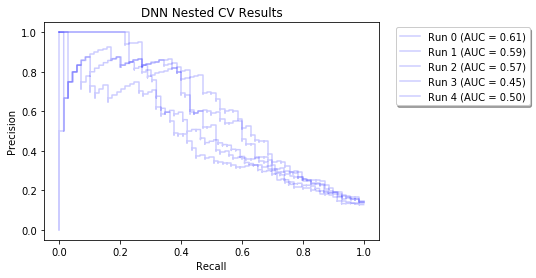

In [38]:
plot_pr_curves(y_test_list, dnn_pred_list, 'DNN Nested CV Results')

# How Similar Are the Methods? #

In [0]:
num_scores = len(rmd_pred_list[0].argsort().argsort())
test0_ranks_df = pd.DataFrame({
                                'rmd': num_scores - rmd_pred_list[0].argsort().argsort(),
                                'knn': num_scores - knn_pred_list[0].argsort().argsort(),
                                'nb': num_scores - nb_pred_list[0].argsort().argsort(),
                                'rf': num_scores - rf_pred_list[0].argsort().argsort(),
                                'svm': num_scores - svm_pred_list[0].argsort().argsort(),
                                'dnn': num_scores - dnn_pred_list[0].argsort().argsort(),
                            })

### Let's plot how the compounds rank each compound, and see how correlated the methods are. Compounds at low ranks are those judged to be most likely to be active by the classifier.

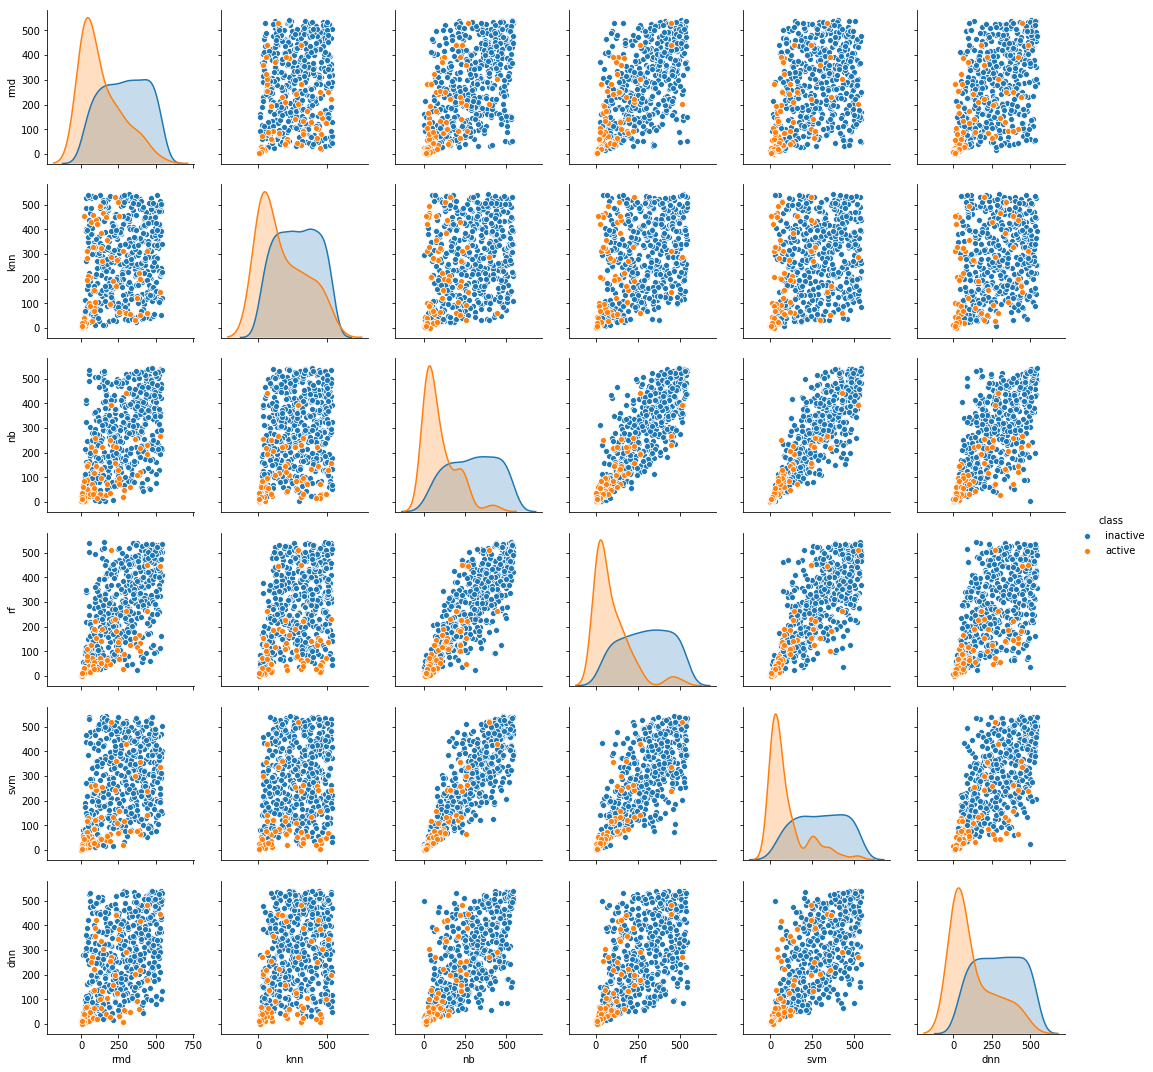

In [40]:
import seaborn as sns

test0_ranks_df['class'] = y_test_list[0]
test0_ranks_df['class'] = test0_ranks_df['class'].apply(lambda x: 'active' if x==1 else 'inactive')
sns.pairplot(test0_ranks_df, hue='class')

### Let's do it for one more test set:

In [0]:
num_scores = len(rmd_pred_list[0].argsort().argsort())
test5_ranks_df = pd.DataFrame({
                                'rmd': num_scores - rmd_pred_list[-1].argsort().argsort(),
                                'knn': num_scores - knn_pred_list[-1].argsort().argsort(),
                                'nb': num_scores - nb_pred_list[-1].argsort().argsort(),
                                'rf': num_scores - rf_pred_list[-1].argsort().argsort(),
                                'svm': num_scores - svm_pred_list[-1].argsort().argsort(),
                                'dnn': num_scores - dnn_pred_list[-1].argsort().argsort(),
                            })

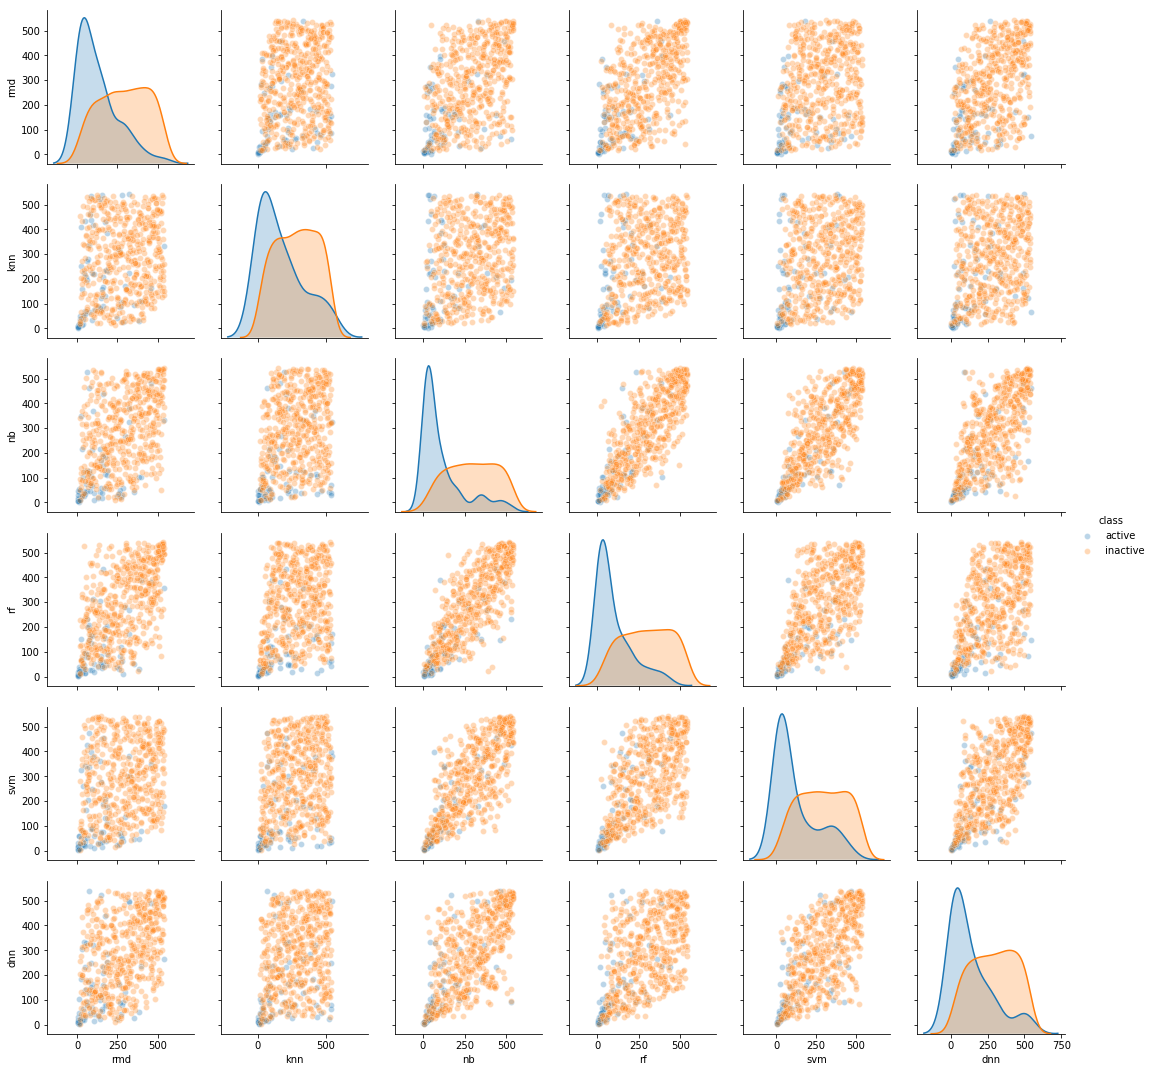

In [48]:
test5_ranks_df['class'] = y_test_list[-1]
test5_ranks_df['class'] = test5_ranks_df['class'].apply(lambda x: 'active' if x==1 else 'inactive')
sns.pairplot(test5_ranks_df, hue='class', plot_kws={'alpha':0.3} )

### The algorithms struggle much more on this fold, and seem relatively uncorrelated, let's see if we can help by using a voting classifier:

In [0]:
voting_aucs_list = []
for i in range(len(y_test_list)):
    vote_ranks_arr = np.vstack((rmd_pred_list[i].argsort().argsort(),
                             knn_pred_list[i].argsort().argsort(),
                             nb_pred_list[i].argsort().argsort(),
                             rf_pred_list[i].argsort().argsort(),
                             svm_pred_list[i].argsort().argsort(),
                             dnn_pred_list[i].argsort().argsort()))
    vote_pred = np.mean(vote_ranks_arr, axis=0)
    
    voting_aucs_list.append(roc_auc_score(y_test_list[i], vote_pred))

In [58]:
voting_aucs_list

[0.8776766757658477,
 0.8695025781013043,
 0.8780395136778115,
 0.8771353684859698,
 0.865618254702436]

In [59]:
np.mean(voting_aucs_list)

0.8735944781466738

In [61]:
np.std(voting_aucs_list)

0.005085752040430002

In [0]:
X_test_list = []
sss = StratifiedKFold(n_splits=5, random_state=42,
                          shuffle=False)
for train_index, test_index in sss.split(X, y): 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_test_list.append(X_test)

In [0]:
def tanimoto(v1, v2):
    """
    Calculates tanimoto similarity for two bit vectors
    """
    return(np.bitwise_and(v1, v2).sum() / np.bitwise_or(v1, v2).sum())

dists = []
fps = X_test_list[0]
activity = y_test_list[0]
active_fps = fps[activity==1]
nfps = active_fps.shape[0]

fp_sims_list = []
for i in range(nfps):
    sims = []
    for j in range(nfps):
        if i != j:
            sims.append(tanimoto(active_fps[i], active_fps[j]))
    fp_sims_list.append(np.mean(sims))

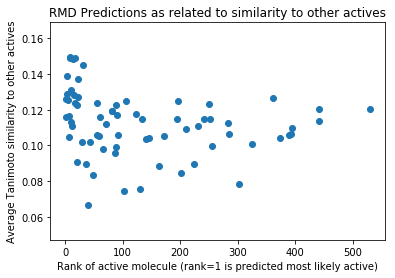

In [81]:
plt.scatter(num_scores - rmd_pred_list[0].argsort().argsort()[activity==1], fp_sims_list)
plt.xlabel('Rank of active molecule (rank=1 is predicted most likely active)')
plt.ylabel('Average Tanimoto similarity to other actives')
plt.title('RMD Predictions as related to similarity to other actives');

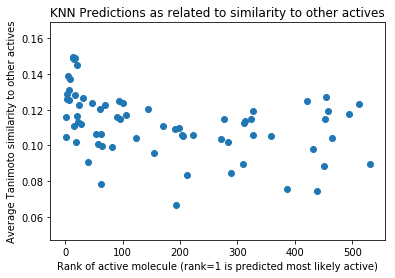

In [82]:
plt.scatter(num_scores - knn_pred_list[0].argsort().argsort()[activity==1], fp_sims_list)
plt.xlabel('Rank of active molecule (rank=1 is predicted most likely active)')
plt.ylabel('Average Tanimoto similarity to other actives')
plt.title('KNN Predictions as related to similarity to other actives');

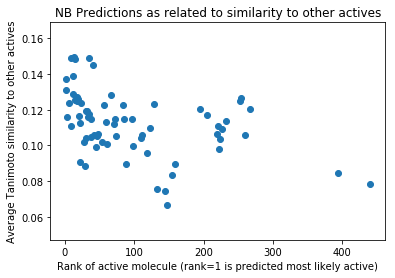

In [83]:
plt.scatter(num_scores - nb_pred_list[0].argsort().argsort()[activity==1], fp_sims_list)
plt.xlabel('Rank of active molecule (rank=1 is predicted most likely active)')
plt.ylabel('Average Tanimoto similarity to other actives')
plt.title('NB Predictions as related to similarity to other actives');

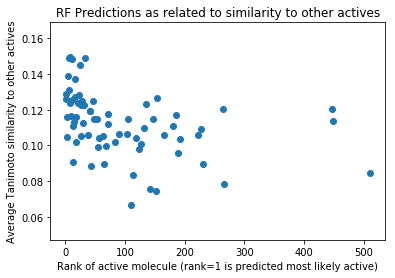

In [85]:
plt.scatter(num_scores - rf_pred_list[0].argsort().argsort()[activity==1], fp_sims_list)
plt.xlabel('Rank of active molecule (rank=1 is predicted most likely active)')
plt.ylabel('Average Tanimoto similarity to other actives')
plt.title('RF Predictions as related to similarity to other actives');

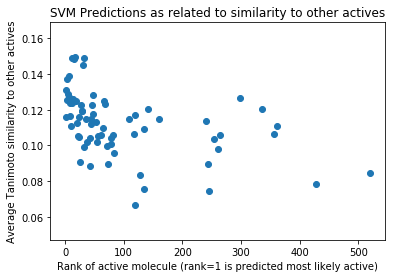

In [86]:
plt.scatter(num_scores - svm_pred_list[0].argsort().argsort()[activity==1], fp_sims_list)
plt.xlabel('Rank of active molecule (rank=1 is predicted most likely active)')
plt.ylabel('Average Tanimoto similarity to other actives')
plt.title('SVM Predictions as related to similarity to other actives');

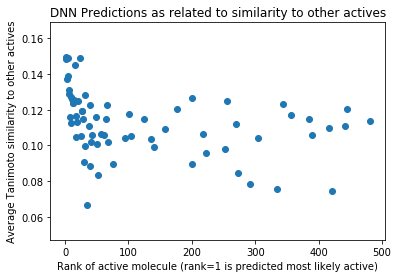

In [87]:
plt.scatter(num_scores - dnn_pred_list[0].argsort().argsort()[activity==1], fp_sims_list)
plt.xlabel('Rank of active molecule (rank=1 is predicted most likely active)')
plt.ylabel('Average Tanimoto similarity to other actives')
plt.title('DNN Predictions as related to similarity to other actives');